## **作業四、深度機器學習在影像辨識與生成的練習 - 1**
#### 姓名：謝元皓
#### 學號：410978002
<hr>

### 資料介紹
- 耶魯大學38位學生的面孔
- 總共2410張，每張圖片大小為192*168
### 作品目標
1. 用 PyTorch 建立卷積神經網路 (CNN) 進行 Yale Face 人臉辨識
2. 建立完模型後，對模型進行訓練及評估
3. 載入已訓練的模型，對新的測試影像進行預測並列印辨識結果。
<HR>


# 1. 觀察原資料
## Step 1 載入此作業需要的套件

In [33]:
import matplotlib.pyplot as plt 
# 繪圖用
import pandas as pd 
# 數據處理
import scipy.io 
# 科學計算
import numpy as np 
# 數值計算
from scipy.io import loadmat 
#導入loadmat函數，讀取matlab文建
from sklearn.model_selection import train_test_split 
#用於將數據集分割成訓練集和測試集
from sklearn.preprocessing import StandardScaler 
#準化工具，用於將數據的均值和標準差調整到0和1
import torch 
#PyTorch是一個深度學習框架，用於建立和訓練神經網絡
from torch.utils.data import TensorDataset 
# TensorDataset是PyTorch中的一個數據結構，用於將數據張量和標籤張量封裝在一起
from torch.utils.data import DataLoader, random_split 
# DataLoader用於在訓練模型時批量讀取數據。random_split用於隨機分割數據集
import torchvision.transforms as transforms 
# Torchvision是PyTorch的計算機視覺工具包。transforms模組提供圖像轉換工具，用於數據增強和預處理
import torchvision.datasets as datasets
# datasets模組提供了一些常用的數據集加載工具
import torch.nn as nn
# nn模組提供了構建神經網絡所需的層和模型
import torch.nn.functional as F
# nn.functional模組提供了一些常用的神經網絡操作和激活函數。
import torchvision
# Torchvision是一個用於計算機視覺任務的PyTorch庫，包含常用的數據集、模型結構和圖像轉換工具。
import cv2
# OpenCV是一個開源計算機視覺和圖像處理庫，提供多種圖像和視頻處理功能
from torch import optim
# optim模組提供了各種優化算法，用於訓練神經網絡
from sklearn.preprocessing import LabelEncoder
# LabelEncoder是Scikit-learn中的一個工具，用於將分類標籤轉換為數字格式。

## STEP2 查看資料及圖片

C:\Users\Howard\AppData\Local\Temp\ipykernel_23992\1540047351.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n_persons = int(D['person'])


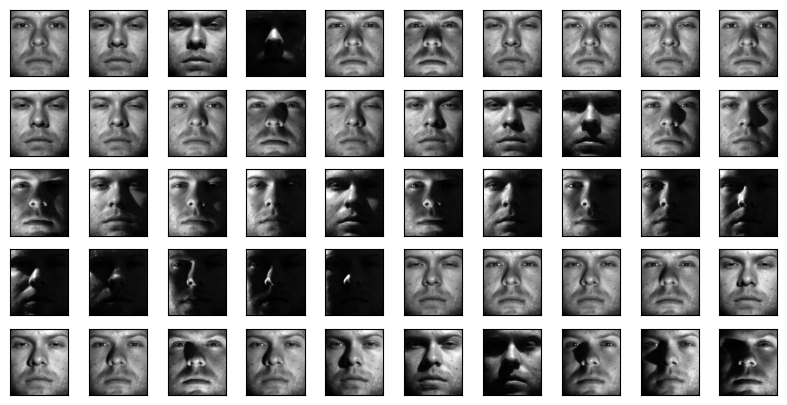

In [4]:
def show_montage(X, n, m, h, w):
    fig, axes = plt.subplots(h, w, figsize=(w, h))
    if X.shape[1] < w * h: 
        X = np.c_[X, np.zeros((X.shape[0], w*h - X.shape[1]))] 
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[:,i].reshape(m, n).T, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
plt.show() 
D = scipy.io.loadmat('allFaces.mat')
X = D['faces'] #32256*2410
X = X.T
k = np.ndarray.flatten(D['nfaces'])
n_persons = int(D['person'])
show_montage(X.T, 192, 168 ,5, 10)

# 2. 資料預處理
## Step1 定義資料轉換&載入資料集

In [15]:
# 轉換數據形狀
X = X.reshape(-1, 1, 192, 168)  # (2410, 1, 192, 168)

# 建立標籤
labels = []
for i in range(n_persons):
    labels.extend([i] * k[i])
labels = np.array(labels)

# 標籤編碼
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
y = torch.tensor(y, dtype=torch.long)
X = torch.tensor(X, dtype=torch.float32)

C:\Users\Howard\AppData\Local\Temp\ipykernel_23992\2235792190.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)


tensor([ 0,  0,  0,  ..., 37, 37, 37])

### 設定每張圖的Label，並將其轉為tensor型態，以利後續訓練及測試。

# 3. 建立CNN模型

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 48 * 42, 128)
        self.fc2 = nn.Linear(128, n_persons)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 48 * 42)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x



## 建置模型解釋
這段程式碼定義了一個卷積神經網絡（CNN）模型類別，用於圖像分類或其他計算機視覺任務。以下是詳細的解釋：

### 類別定義
```python
class CNN(nn.Module):
```
這行定義了一個名為`CNN`的類別，繼承自`nn.Module`。這是PyTorch中所有神經網絡模型的基礎類別。

### 初始化方法
```python
def __init__(self):
    super(CNN, self).__init__()
```
這行初始化類別，並調用父類的初始化方法，確保父類中的所有屬性都被正確初始化。

### 定義卷積層和全連接層
```python
self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
self.fc1 = nn.Linear(64 * 48 * 42, 128)
self.fc2 = nn.Linear(128, n_persons)
self.relu = nn.ReLU()
```
- **self.conv1**: 定義第一個卷積層，輸入通道為1（灰度圖像），輸出通道為32，卷積核大小為3x3，並使用填充保持輸出大小不變。
- **self.pool**: 定義一個最大池化層，池化窗口大小為2x2，步長為2，這會將特徵圖的大小減半。
- **self.conv2**: 定義第二個卷積層，輸入通道為32，輸出通道為64，卷積核大小為3x3，並使用填充保持輸出大小不變。
- **self.fc1**: 定義第一個全連接層，將卷積層輸出的特徵展平後作為輸入，輸入大小為`64 * 48 * 42`，輸出大小為128。
- **self.fc2**: 定義第二個全連接層，輸入大小為128，輸出大小為`n_persons`（假設是分類的類別數）。
- **self.relu**: 定義ReLU激活函數。

### 前向傳播方法
```python
def forward(self, x):
    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = x.view(-1, 64 * 48 * 42)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    return x
```
- **x = self.pool(self.relu(self.conv1(x)))**: 將輸入`x`通過第一個卷積層、ReLU激活函數和最大池化層。
- **x = self.pool(self.relu(self.conv2(x)))**: 將中間結果`x`通過第二個卷積層、ReLU激活函數和最大池化層。
- **x = x.view(-1, 64 * 48 * 42)**: 將卷積層的輸出展平為一維張量，以便輸入到全連接層。`-1`表示自動計算批量大小。
- **x = self.relu(self.fc1(x))**: 將展平的特徵通過第一個全連接層和ReLU激活函數。
- **x = self.fc2(x)**: 將中間結果通過第二個全連接層，輸出最終的分類結果。
- **return x**: 返回最終輸出。

### 注意事項
- 這個模型假設輸入圖像的大小和卷積層、池化層的配置會產生`64 * 48 * 42`的特徵展平輸出大小。這取決於輸入圖像的大小和池化操作。
- `n_persons`變數應該在類別外部定義，表示分類任務中類別的數量。

# 4. 資料集和訓練過程

In [14]:
# 分割資料集
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 資料載入器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 訓練參數
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練模型
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
                
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

# 評估模型
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy: {100 * correct / total:.2f}%')

# 保存模型
torch.save(model.state_dict(), 'cnn_yale_face.pth')

Epoch 1/20, Loss: 55.76197870832975
Epoch 2/20, Loss: 3.4723307070184926
Epoch 3/20, Loss: 1.4034680763228995
Epoch 4/20, Loss: 0.15026585455434244
Epoch 5/20, Loss: 0.06794326096490698
Epoch 6/20, Loss: 0.0501385114898096
Epoch 7/20, Loss: 0.010648194147506729
Epoch 8/20, Loss: 0.00878677327308964
Epoch 9/20, Loss: 0.007273206744938478
Epoch 10/20, Loss: 0.005011604135733414
Epoch 11/20, Loss: 0.006665776783169438
Epoch 12/20, Loss: 0.001287638659393496
Epoch 13/20, Loss: 0.000655608986950237
Epoch 14/20, Loss: 0.00045708606859213923
Epoch 15/20, Loss: 0.0003497214967928514
Epoch 16/20, Loss: 0.0002933644181636931
Epoch 17/20, Loss: 0.00023792393501368724
Epoch 18/20, Loss: 0.00020196458656934483
Epoch 19/20, Loss: 0.00016518994192904116
Epoch 20/20, Loss: 0.00013976220178638408
Accuracy: 90.87%


## **<結果與討論>**
### 分割資料集
- 分割資料集，取80%的資料訓練，剩下20%的資料測試。
- 將特徵 `X`與標籤 `y`組合成一個 TensorDataset 對象，方便後續處理。
### 資料載入器
- DataLoader(train_dataset, batch_size=32, shuffle=True): 創建訓練資料載入器，每次載入32個樣本，並在每個epoch開始時打亂數據。
- DataLoader(test_dataset, batch_size=32, shuffle=False): 創建測試資料載入器，每次載入32個樣本，並且不打亂數據。
### 訓練參數
- torch.device('cuda' if torch.cuda.is_available() else 'cpu'): 檢查是否有GPU可用，如果有，則使用GPU，否則使用CPU。
- model = CNN().to(device): 創建CNN模型實例，並將其移動到指定的設備（CPU或GPU）。
- criterion = nn.CrossEntropyLoss(): 定義損失函數，這裡使用交叉熵損失，常用於多分類問題。
- optimizer = optim.Adam(model.parameters(), lr=0.001): 定義優化器，這裡使用Adam優化器，並設置學習率為0.001。


### 訓練過程
每個epoch的輸出格式為`Epoch {epoch}/{num_epochs}`, 

`Loss: {running_loss/len(train_loader)}`，這表示該epoch結束時的平均損失。

- Epoch 1/20, Loss: 55.76197870832975: 在第1個epoch，模型的平均損失為55.76。這表示模型在剛開始訓練時的誤差非常大。
- Epoch 2/20, Loss: 3.4723307070184926: 在第2個epoch，損失顯著下降到3.47，表明模型開始學習和改善。
- Epoch 3/20, Loss: 1.4034680763228995: 在第3個epoch，損失進一步下降到1.40，模型繼續改善。
- Epoch 4/20, Loss: 0.15026585455434244: 到第4個epoch，損失大幅下降到0.15，表明模型已經在訓練資料上有了很好的性能。
- Epoch 5/20, Loss: 0.06794326096490698: 第5個epoch，損失進一步降低到0.068，表明模型性能繼續提升。
- 從第6個epoch開始，損失繼續減少，最終在第20個epoch時降到接近零的程度：

損失在每個epoch中逐漸減少，這表示模型在訓練資料上的性能持續提高。特別是從第12個epoch開始，損失變得非常小，這表明模型幾乎完全擬合了訓練數據。
### 評估模型
- 90.87%是一個非常高的準確率，表明模型在未見過的測試資料上也能很好地進行分類。
### 總結
- 損失從開始的55.76快速下降到接近零，顯示了模型在訓練過程中的快速學習和優化。
- 測試集準確率為90.87%，表明模型具有很好的泛化能力，在未見過的數據上表現良好。
- 由於訓練時間不足，故訓練20次epochs。
整體來看，這段訓練過程顯示了模型從初始訓練到最終達到高準確率的過程，顯示了模型的有效性。

# 5. 使用預訓練模型進行預測

In [58]:
# 載入預訓練模型
model = CNN()
model.load_state_dict(torch.load('cnn_yale_face.pth'))
model.eval()

# 預測函數
def predict_image(model, image):
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        return predicted.item()

# 載入測試圖像
test_image = test_dataset[0][0].unsqueeze(0)  # 假設我們使用測試集中的第一張圖片作為範例

# 預測圖像的標籤
predicted_label = predict_image(model, test_image)
print(f'Predicted Label: {label_encoder.inverse_transform([predicted_label])[0]}')


Predicted Label: 1


 ### **<結果與討論>**

以上程式碼中的函數 `predict_image` 是用來對一張圖像進行預測的。讓我們來解釋這個函數的運作流程：

1. **載入預訓練模型：** 首先，我們載入了預先訓練好的卷積神經網路模型 `model`，並將其設置為評估模式 (`model.eval()`)。這個步驟確保模型在進行預測時不會進行梯度計算。

2. **定義預測函數：** 我們定義了一個名為 `predict_image` 的函數，它接受兩個參數：已載入的模型 `model` 和要進行預測的圖像 `image`。

3. **進行預測：** 在 `predict_image` 函數中，我們使用 `torch.no_grad()` 上下文管理器，這個管理器會停止 PyTorch 計算梯度，因為在預測過程中我們不需要計算梯度。然後，我們將圖像 `image` 傳入模型中，獲取模型的輸出。

4. **處理模型輸出：** 我們通過 `torch.max()` 函數來獲取模型輸出中每個類別的分數及其對應的索引。由於我們只對應的索引感興趣，因此使用 `_` 來丟棄分數。然後，我們使用 `.item()` 方法獲取預測的類別索引值。

5. **反轉標籤編碼：** 最後，我們使用 `label_encoder.inverse_transform()` 將預測的類別索引值反轉回原始的類別標籤，並將其列印出來。

總的來說，`predict_image` 函數接收一張圖像並使用預訓練的 CNN 模型進行預測，然後將預測的標籤轉換為人類可讀的格式並返回。